<a href="https://colab.research.google.com/github/alexander-toschev/cv-course/blob/main/ImageProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25836 sha256=0f5b891fded7a20f16ce78d91d1ad2b19ba5cf58278f6da99e7e10bd488826d6
  Stored in directory: /Users/alex/Library/Caches/pip/wheels/59/1b/52/0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils


In [14]:
import numpy as np
import pandas as pd
import cv2 as cv2
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
from skimage.transform import pyramid_gaussian
import imutils

In [15]:
# Create a list to store the urls of the images
urls = ["https://upload.wikimedia.org/wikipedia/commons/a/a8/Cat_public_domain_dedication_image_0011.jpg"]  
# Read and display the image
# loop over the image URLs, you could store several image urls in the list

for url in urls:
  image = io.imread(url) 
  image_2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  final_frame = cv2.hconcat((image, image_2))
  #cv2_imshow(final_frame)
  print('\n')


image[100,100] = [255,255,255]
print( image[100,100] )



[255 255 255]


Image histogramm

(0.0, 256.0)

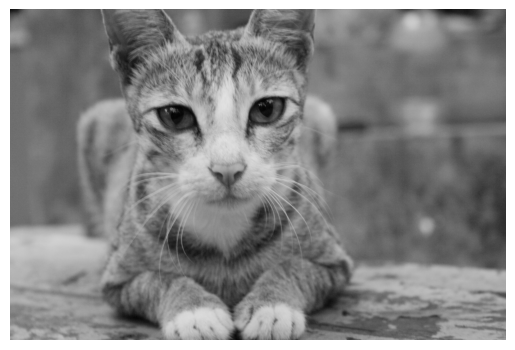

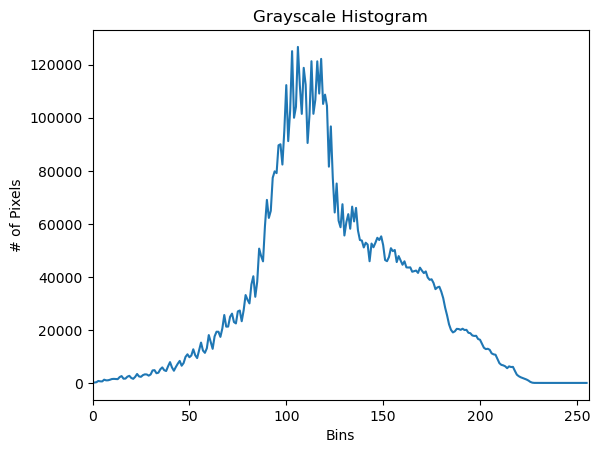

In [16]:
image2 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([image2], [0], None, [256], [0, 256])
# matplotlib expects RGB images so convert and then display the image
# with matplotlib
plt.figure()
plt.axis("off")
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_GRAY2RGB))
# plot the histogram
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])

Linear filtering blurring the image
Question why source image size the same? use matrix represntation to study it.



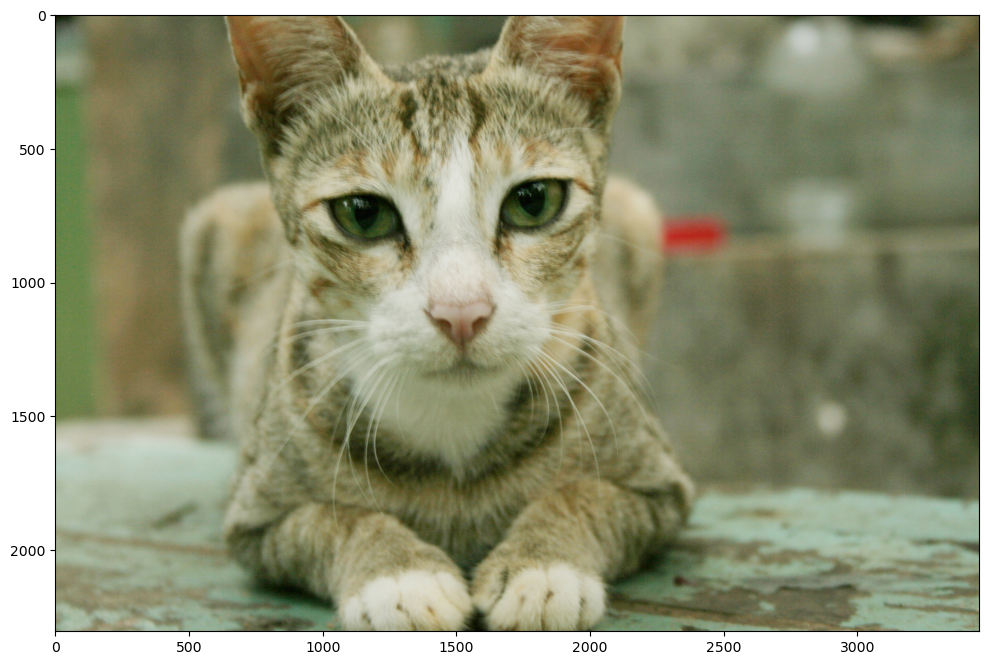

In [17]:
kernel = np.ones((3, 3), np.float32) / 9
img = cv2.filter2D(image, -1, kernel)
fig, ax = plt.subplots(1, figsize=(12,8))

plt.imshow(image)


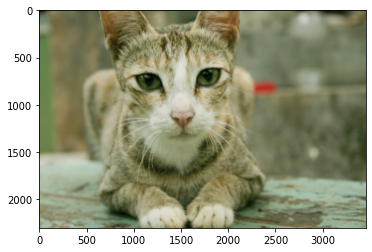

In [ ]:
plt.imshow(img)

Implement non linear filters -- median and bilateral

# 5. Fourier transform
У Numpy есть программный пакет FFT для выполнения этой операции.np.fft.fft2() предоставляет нам преобразование частоты, которое будет сложным массивом.

как только результат будет получен, нулевая частотная составляющая (составляющая постоянного тока) будет в верхнем левом углу.

Если вы хотите центрировать его, вам нужно переместить результат $ frac {N} {2} $ в обоих направлениях. Просто передайте функциюnp.fft.fftshift() завершить. (Проще анализировать). 

[[185.32685124 137.31527301 149.70546155 ... 165.07247705 149.70546155
  137.31527301]
 [151.50387395 165.5223695  128.2731543  ... 140.46335616 162.91740561
  127.1160839 ]
 [163.1205181  148.16100656 176.79522729 ... 134.04638532 151.77451887
  141.53171265]
 ...
 [165.33160509 156.30326067 145.24028059 ... 155.39286462 144.69513869
  157.71254056]
 [163.1205181  141.53171265 151.77451887 ... 156.77020886 176.79522729
  148.16100656]
 [151.50387395 127.1160839  162.91740561 ... 158.86121973 128.2731543
  165.5223695 ]]


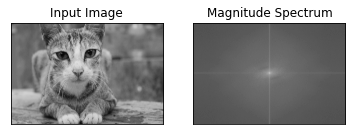

In [12]:
# use gray image
f = np.fft.fft2(image2) # 2 dimensional discrete fourier transform
fshift = np.fft.fftshift(f) # shift zero frequenct component to the center of spectrum
magnitude_spectrum = 20*np.log(np.abs(fshift))
print(magnitude_spectrum)
plt.subplot(121),plt.imshow(image2, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()



Теперь вы можете выполнять некоторые операции в частотной области, такие как фильтрация верхних частот и реконструкция изображения, то есть найти обратное ДПФ. Для этого вам нужно всего лишь использовать прямоугольную оконную маску 60x60 для устранения низких частот. Затем используйтеnp.fft.ifftshift() Примените обратный сдвиг, чтобы компонент постоянного тока снова появился в верхнем левом углу. Затем используйтеnp.ifft2Функция () находит обратное БПФ. Опять же, результатом будет комплексное число. Вы можете использовать его абсолютное значение.

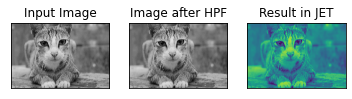

In [ ]:
img= image2
rows, cols = img.shape
crow,ccol = rows//2 , cols//2
fshift[crow-30:crow-31, ccol-30:ccol-31] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.real(img_back)
plt.subplot(131),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img_back)
plt.title('Result in JET'), plt.xticks([]), plt.yticks([])
plt.show()

Результат показывает, что фильтрация верхних частот - это операция обнаружения края. Это то, что мы видели в главе «Градация изображения». Это также показывает, что большая часть данных изображения существует в низкочастотной области спектра. В любом случае, мы видели, как найти DFT, IDFT и т.д. в Numpy. Теперь посмотрим, как это сделать в OpenCV. Если вы внимательно посмотрите на результаты, особенно на последнее цветное изображение JET, вы увидите некоторые артефакты (экземпляр, который я пометил красной стрелкой). Там изображена гофрированная структура, называемаяЭффект звонка, Это вызвано прямоугольным окном, которое мы использовали для маскировки. Эта маска преобразуется в синусоидальную форму, что и вызывает эту проблему. Следовательно, прямоугольное окно не используется для фильтрации. Лучшим выбором является окно Гаусса.

*Задача*

Отфильтровать центр кошки, используя иные алгоритмы обнаружения частот.
Аналогичный вопрос поднимался и на форуме. Вопрос в том, почему преобразование Лапласа является фильтром верхних частот? Почему Собел - фильтром высоких частот? И т. Д. Первый ответ касается преобразования Фурье. Для больших БПФ требуется только преобразование Лапласа. Проанализируйте следующий код, расскажите что значит преобразование Лапласса, собел, scahrr. Восстановите изображение после фильтрации:

1. FFT the image
2. FFT the kernel, padded to the size of the image
3. multiply the two in the frequency domain (equivalent to convolution in the spatial domain)
4. IFFT (inverse FFT) the result



(<matplotlib.axes._subplots.AxesSubplot at 0x7fa2ffa6bd90>,
 <matplotlib.image.AxesImage at 0x7fa2ff93d510>)

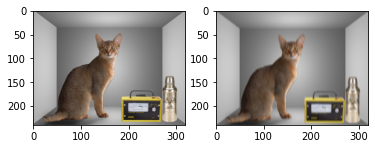

In [38]:
from scipy import fftpack


# sample convolution for the gaussin blur
img = plt.imread("https://upload.wikimedia.org/wikipedia/commons/0/0d/Schr%C3%B6dinger_cat.png")
# TODO diff between io and plt 
#image_2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.hconcat(img, image_2)
plt.subplot(121),plt.imshow(img)
  # First a 1-D  Gaussian
t = np.linspace(-10, 10, 30)
bump = np.exp(-0.1*t**2)
bump /= np.trapz(bump) # normalize the integral to 1

# make a 2-D kernel out of it
kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
kernel = cv2.getGaussianKernel(5,10)
#kernel = x*x.T
#print(kernel)
# Padded fourier transform, with the same shape as the image
# We use :func:`scipy.signal.fftpack.fft2` to have a 2D FFT
kernel_ft = fftpack.fft2(kernel, shape=img.shape[:2], axes=(0, 1))

# convolve
img_ft = fftpack.fft2(img, axes=(0, 1))

# the 'newaxis' is to match to color direction
img2_ft = kernel_ft[:, :, np.newaxis] * img_ft
img2 = fftpack.ifft2(img2_ft, axes=(0, 1)).real

# clip values to range to suite the RGB
img2 = np.clip(img2, 0, 1)

plt.subplot(122),plt.imshow(img2)
#plt.imshow(img2, cmap = 'gray')


In [ ]:

 # Простой средний фильтр без параметров масштабирования
mean_filter = np.ones((3,3))
 # Создать фильтр Гаусса
x = cv2.getGaussianKernel(5,10)
gaussian = x*x.T
 # Различные фильтры обнаружения края
 # scharr в направлении x
scharr = np.array([[-3, 0, 3],
                   [-10,0,10],
                   [-3, 0, 3]])
 # собел в направлении x
sobel_x= np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
 # собел в направлении y
sobel_y= np.array([[-1,-2,-1],
                   [0, 0, 0],
                   [1, 2, 1]])
 # Преобразование Лапласа
laplacian=np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])
filters = [mean_filter, gaussian, laplacian, sobel_x, sobel_y, scharr]
filter_name = ['mean_filter', 'gaussian','laplacian', 'sobel_x', \
                'sobel_y', 'scharr_x']
fft_filters = [np.fft.fft2(x) for x in filters]
fft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)) for z in fft_shift]
for i in iter(range(6)):
    plt.subplot(2,3,i),plt.imshow(mag_spectrum[i],cmap = 'gray')
    plt.title(filter_name[i]), plt.xticks([]), plt.yticks([])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


ValueError: ignored

<Figure size 432x288 with 0 Axes>

# 6 Пирамиды и вейвлеты

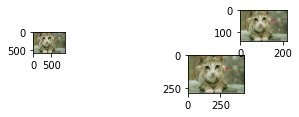

In [ ]:

def pyramid(image_, scale=2, minSize=(100, 100)):
	# yield the original image
	yield image_
	# keep looping over the pyramid
	while True:
		# compute the new dimensions of the image and resize it
		w = int(image_.shape[1] / scale)
		image_ = imutils.resize(image_, width=w)
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image_.shape[0] < minSize[1] or image_.shape[1] < minSize[0]:
			break
		# yield the next image in the pyramid
		yield image_

# METHOD #1: No smooth, just scaling.
# loop over the image pyramid
index = 0
for (i, resized) in enumerate(pyramid(image)):
	# show the resized image
  index = index + 1 + 130
  plt.subplot(index),plt.imshow(resized)
  
	


Заставить работать второй метод.

In [ ]:
# close all windows
index = 0
# METHOD #2: Resizing + Gaussian smoothing.
for (i, resized) in enumerate(pyramid_gaussian(image, downscale=1.5)):
	# if the image is too small, break from the loop
  if resized.shape[0] < 100 or resized.shape[1] < 100:
    break
  index = index + 1 + 140
  plt.subplot(index),plt.imshow(resized.squeeze())

plt.show()

# Вейвлеты

Estimated Gaussian noise standard deviation = 0.11912568322211949


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


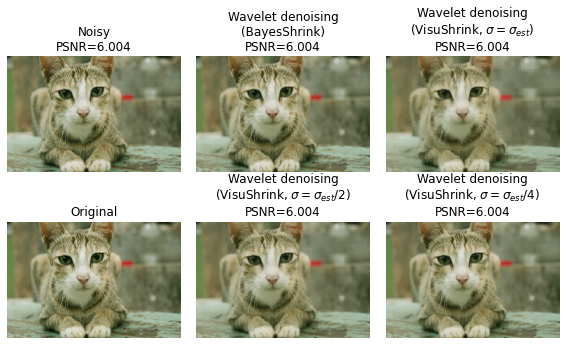

In [ ]:

from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio

original = image # img_as_float(data.chelsea()[100:250, 50:300])

sigma = 0.12
noisy = random_noise(original, var=sigma**2)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 5),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, average_sigmas=True,  multichannel=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

im_bayes = denoise_wavelet(noisy, convert2ycbcr=True,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True, multichannel=True)
im_visushrink = denoise_wavelet(noisy, convert2ycbcr=True,
                                method='VisuShrink', mode='soft',
                                sigma=sigma_est, rescale_sigma=True, multichannel=True)

# VisuShrink is designed to eliminate noise with high probability, but this
# results in a visually over-smooth appearance.  Repeat, specifying a reduction
# in the threshold by factors of 2 and 4.
im_visushrink2 = denoise_wavelet(noisy,  convert2ycbcr=True,
                                 method='VisuShrink', mode='soft',
                                 sigma=sigma_est/2, rescale_sigma=True, multichannel=True)
im_visushrink4 = denoise_wavelet(noisy,  convert2ycbcr=True,
                                 method='VisuShrink', mode='soft',
                                 sigma=sigma_est/4, rescale_sigma=True, multichannel=True)

# Compute PSNR as an indication of image quality
psnr_noisy = peak_signal_noise_ratio(original, noisy)
psnr_bayes = peak_signal_noise_ratio(original, im_bayes)
psnr_visushrink = peak_signal_noise_ratio(original, im_visushrink)
psnr_visushrink2 = peak_signal_noise_ratio(original, im_visushrink2)
psnr_visushrink4 = peak_signal_noise_ratio(original, im_visushrink4)

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title(f'Noisy\nPSNR={psnr_noisy:0.4g}')
ax[0, 1].imshow(im_bayes)
ax[0, 1].axis('off')
ax[0, 1].set_title(
    f'Wavelet denoising\n(BayesShrink)\nPSNR={psnr_bayes:0.4g}')
ax[0, 2].imshow(im_visushrink)
ax[0, 2].axis('off')
ax[0, 2].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}$)\n'
     'PSNR=%0.4g' % psnr_visushrink)
ax[1, 0].imshow(original)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')
ax[1, 1].imshow(im_visushrink2)
ax[1, 1].axis('off')
ax[1, 1].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}/2$)\n'
     'PSNR=%0.4g' % psnr_visushrink2)
ax[1, 2].imshow(im_visushrink4)
ax[1, 2].axis('off')
ax[1, 2].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}/4$)\n'
     'PSNR=%0.4g' % psnr_visushrink4)
fig.tight_layout()

plt.show()

**Задача** Восстановите свое изображение

**Задача** возьмите фотографию и добавьте туда призрака